<a href="https://colab.research.google.com/github/williamsdoug/CTG_RP/blob/master/CTG_RP_Generate_Recurrence_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CTG Generate Reccurence Plots

In [0]:
import config_local
from config_local import *
#from config_common import *

In [0]:
import os
import json
from pprint import pprint

import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt

import wfdb
from ctg_utils import get_all_recno, parse_meta_comments
import basic_denoise
from basic_denoise import get_valid_segments

from libRP import create_rp

In [0]:
# Used to update individual file during debug
#get_github_files(['basic_denoise.py'])
#! cat basic_denoise.py

# Config

# Code

In [0]:
def generate_rp_images(recordings_dir, n_dec=4, clip_stage_II=True, 
                       max_seg_min=10, policy='early_valid',
                       rp_params=[{}],
                       images_dir='',
                       images_index_file='rp_images_index.json',
                       show_signal=False, show_image=False, verbose=False, cmap=None,
                       limit=-1):
    
    assert policy in ['best_quality', 'early_valid', 'late_valid']
    
    if images_dir and not os.path.exists(images_dir):
        os.mkdir(images_dir)
        
    max_seg = int(max_seg_min*60*4)  # convert to samples

    results = {}
    for recno in sorted(get_all_recno(recordings_dir)):
        limit -= 1
        if limit == 0:
            break
            
        recno_full = os.path.join(recordings_dir, recno)
        all_sig, meta = wfdb.io.rdsamp(recno_full)
        meta = parse_meta_comments(meta['comments'])
        if verbose:
            print('\nRecord: {}  Samples: {}   Duration: {:0.1f} min   Stage.II: {} min'.format(
                recno, all_sig.shape[0], all_sig.shape[0]/4/60, meta['Delivery']['II.stage']))

        sig_hr = all_sig[:, 0]
        if clip_stage_II and meta['Delivery']['II.stage'] != -1:
            idx = int(meta['Delivery']['II.stage']*60*4)
            sig_hr = sig_hr[:-idx]
        ts = np.arange(len(sig_hr))/4.0
            
        if show_signal:
            plt.figure(figsize=(12, 2))
            plt.title('{}: Signal'.format(recno))
            plt.plot(ts/60, sig_hr)
            plt.xlim(ts[0], ts[-1]/60)
            plt.ylim(50, 200)
            plt.show()
            
        # select segment with lowest error rate
        selected_segments = get_valid_segments(sig_hr, ts, recno, verbose=False)
        
        if len(selected_segments) == 0:
            continue
        
        if policy == 'best_quality':
            selected_segments = sorted(selected_segments, key=lambda x: -x['pct_valid'])
        elif policy == 'early_valid':
            selected_segments = sorted(selected_segments, key=lambda x: x['seg_start'])
        elif policy == 'late_valid':
            selected_segments = sorted(selected_segments, key=lambda x: -x['seg_end'])
            
        seg =  selected_segments[0]
        seg_start = seg['seg_start']
        seg_end = seg['seg_end']
        seg_hr = seg['seg_hr']
        seg_tm = seg['seg_ts'] / 60
        orig_seg_hr = seg['orig_seg_hr']
        mask = seg['mask']
        pct_valid = seg['pct_valid']
            
        if show_signal:
            plt.figure(figsize=(12, 2))
            plt.title('{}: Segment  {}-{}'.format(recno, seg_start, seg_end))
            plt.plot(seg_tm, seg_hr)
            plt.plot(seg_tm, orig_seg_hr, alpha=0.25)
            plt.xlim(seg_tm[0], seg_tm[-1])
            plt.ylim(50, 200)
            plt.show()

            plt.figure(figsize=(12, 0.75))
            plt.title('{}: Invalid'.format(recno))
            plt.plot(seg_tm, ~mask)
            plt.xlim(seg_tm[0], seg_tm[-1])
            plt.ylim(-0.1, 1.1)
            plt.show()

            print('Valid: {:0.1f}%'.format(100 * pct_valid))

        selected_hr = seg_hr[:max_seg]
        if n_dec > 1:
            selected_hr = scipy.signal.decimate(selected_hr,n_dec)

        image_names = []
        for p in rp_params:
                fname = create_rp(selected_hr, base_name=recno, show_image=show_image,
                                  images_dir=images_dir, cmap=cmap, **p)
                image_names.append(fname)
                    
        results[recno] = {'names':image_names, 'outcome':meta['Outcome']}

#     if verbose:
#         pprint(results)
    
    with open(os.path.join(images_dir, images_index_file), 'w') as outfile:
        json.dump(results, outfile)

## Process Recordings

In [5]:
# Configure Recurrent Plot Parameters

rp_params = []

for dimension in [2]:
    for time_delay in [1]:
        for percentage in [1,3, 10]:
            for use_clip in [False]: # [False, True]:
                rp_params.append({'dimension':dimension, 'time_delay':time_delay, 
                                  'percentage':percentage, 'use_clip':use_clip})
            
            
rp_params           

[{'dimension': 2, 'percentage': 1, 'time_delay': 1, 'use_clip': False},
 {'dimension': 2, 'percentage': 3, 'time_delay': 1, 'use_clip': False},
 {'dimension': 2, 'percentage': 10, 'time_delay': 1, 'use_clip': False}]


Record: 1001  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min


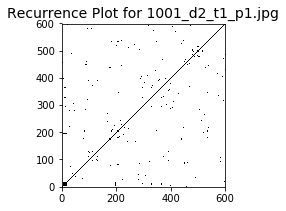


Record: 1002  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min


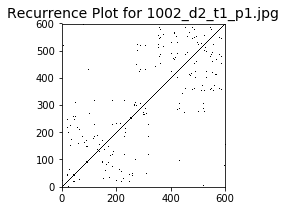

In [6]:
generate_rp_images(RECORDINGS_DIR, images_dir=IMAGES_DIR, rp_params=rp_params[:1], 
                   policy='early_valid', # 'best_quality', 'early_valid', 'late_valid'
                   show_signal=False, show_image=True, verbose=True, cmap='binary',
                   limit=3,
                  )

In [0]:
generate_rp_images(RECORDINGS_DIR, images_dir=IMAGES_DIR, rp_params=rp_params, 
                   policy='early_valid', # 'best_quality', 'early_valid', 'late_valid'
                   show_signal=False, show_image=False, verbose=True, cmap='binary',
#                    limit=3,
                  )

In [8]:
IMAGES_DIR

'/content/images'

In [9]:
ls /content/images/1171*

/content/images/1171_d2_t1_p10.jpg  /content/images/1171_d2_t1_p3.jpg
/content/images/1171_d2_t1_p1.jpg


In [13]:
with open(os.path.join(IMAGES_DIR, 'rp_images_index.json'), 'r') as infile:
        data = json.load(infile)
    
print('Recordings:', len(data.keys()))
print('Sample Recording :', data['1001'])

tally = 0
for k in data.keys():
  for i in data[k]['names']:
      tally += 1
print('Total Images', tally)

Recordings: 544
Sample Recording : {'names': ['1001_d2_t1_p1.jpg', '1001_d2_t1_p3.jpg', '1001_d2_t1_p10.jpg'], 'outcome': {'pH': 7.14, 'BDecf': 8.14, 'pCO2': 7.7, 'BE': -10.5, 'Apgar1': 6, 'Apgar5': 8}}
Total Images 1632


In [0]:
# ! cat /content/images/rp_images_index.json